 # <p style="text-align: center;">  __NOTE: <br />The file coco_to_yolo.py is implemented in this ipynb notebook for straightforward execution by any curious classmates who want a simpler experience__  </p>
 
  ### <p style="text-align: center;">  In addition to that, the entire project will pretty much be in this single, large notebook for those unfamiliar with data science. I believe this will make life easier for those still trying to understand the interplay between models, their backbones, datasets, configurations, training and implementations. Yes I am aware this is not technically best practice which is why I've done my best to properly organize a file structure representing a decent project outside of this single file (my first project of this size)  </p>



> ##### Pao, Oretha, Anto, if y'all are reading this and want to recreate the project just follow the below instructions I've written out and run whats in this notebook along with a few other directions further down.



In [2]:
# Team Definitely Unsure
# David Shockley - Team Leader, Anto Patrick, Oretha Francis

P.S. I am aware this model has been shipped on similar systems but if anybody browsing the internet or future employers are wondering why I tried reinventing the wheel this is for a school project.
  > Specifically, part of the purpose of these projects is to challenge yourself to grow and develop something worthy of submission. Simply shipping yolov4 tiny onto a pi would not have done.



## <p style="text-align: center;"> Import fiftyone, and download coco 2017 images </p>
prerequisites:
- run the following lines (assuming anaconda environment is default and Windows is being used) 
```    
    1.  
        a. Install buildtools from https://visualstudio.microsoft.com/visual-cpp-build-tools/
        
        b. Check desktop development with C++ and install

     2. Open anaconda navigator -> select desired environment -> launch a terminal
     3. > conda install cython
     4. > pip install --user fiftyone

     5.
        a. Unzip the cocoapi-master.zip from this project into a new folder under C:\coco
            i. You may also download it from https://github.com/cocodataset/cocoapi
        b. In file explorer, navigate to C:\coco\cocoapi-master\PythonAPI 
         i. Open setup.py in an editor like vscode
         ii. Comment out line 12 that begins with 'extra_compile_args...' by using #
     6. In the same terminal as before type cd C:\coco\cocoapi-master\PythonAPI
        a. > python setup.py build_ext (to verify no issues)
        b. > python setup.py build_ext install 

This will have installed visual C++ build tools 
    As well as the cython, fiftyone, and the cocoapi libraries.        
```  


TODO: 
> Train model and export weights in saved fp32  
> Evaluate Performance with fewer images like this  
> Ensure model works on live camera with mask overlay  
> FrozenGraph  
> Quantize model for fast inference  
> Write a script for approaching an object  
> Develop Readme better, cite sources for visuals  
> Implement debug logging with logging module  

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz 
import os, sys, re, json, cv2, pickle
import numpy as np
import pandas as pd
from fiftyone.core.dataset import get_default_dataset_dir

project_cwd = globals()['_dh'][0]


In [3]:

#C:\Users\username\fiftyone\coco-2017\raw\instances_train2017.json
dataset = foz.load_zoo_dataset("coco-2017", 
                                label_types = ['detections','segmentations'],
                                classes = ['person'],
                                max_samples = 1500)

Found annotations at 'C:\Users\melti\fiftyone\coco-2017\raw\instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at 'C:\Users\melti\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Test split is unlabeled; ignoring classes requirement
Found test info at 'C:\Users\melti\fiftyone\coco-2017\raw\image_info_test2017.json'
Sufficient images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'coco-2017-1500'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Verify that the installation was successful by launching the cocos dataset in fiftyone. 
> #### If no session is needed then disregard the next cell

In [ ]:
# Launch a standalone fiftyone session
session = fo.launch_app(dataset)

#### __The following scripts will convert any files downloaded from fiftyone to a bbox format__

In [155]:
def get_train_test_val_datadirs(fiftyone_default_dataset):
    """
    Assuming a fiftyone dataset object is passed in,
    this method will return the folders associated with those directories
    ARGS:
        fiftyone_default_dataset -> fiftyone.core.dataset.Dataset
            Dataset singleton instance object thing. I'm still wrapping my head around it to be honest.
    RETURNS:
        _train_dir -> str
            path to train directory (not data folder directly, but the json file location)
        _test_dir -> str
            path to test directory (not data folder directly, but the json file location)
        _val_dir -> str
            path to validation directory (not data folder directly, but the json file location)            
    """
    
    datadir = get_default_dataset_dir(fiftyone_default_dataset)
    origin_cwd = globals()['_dh'][0]
    
    os.chdir(datadir)

    _train_dir = f'{os.getcwd()}/train'
    _test_dir = f'{os.getcwd()}/test'
    _val_dir = f'{os.getcwd()}/validation'
    
    os.chdir(origin_cwd)
    
    return _train_dir, _test_dir, _val_dir

In [159]:
# TODO docstring

def convert_to_df_with_bbox(json_file, path, classmap):
    json_file = json.loads(json_file)
    
    filename_map = {}
    classes = classmap.keys()
    
    image_info = pd.DataFrame(json_file['annotations'])
    dim_info = pd.DataFrame(json_file['images'])

    image_info = image_info[image_info['category_id'].isin(classes)].replace(to_replace = {'category_id': classmap})
    
    image_info = image_info.sort_values('image_id')
    dim_info = dim_info.sort_values('file_name')
    list_of_filenames = dim_info['file_name'].to_list()

    
    for filename in list_of_filenames:
        imgid = filename.strip('0')
        imgid = imgid.strip('.jpg')
        filename_map[int(imgid)] = filename
    image_info = image_info.replace(to_replace = {'image_id': filename_map})

    merged_df = pd.merge_ordered(image_info, dim_info, fill_method = 'ffill',left_on = 'image_id', right_on = 'file_name' )
    merged_df = merged_df.drop(['date_captured','image_id','flickr_url', 'license','coco_url','segmentation','area','iscrowd', 'id_x', 'id_y'], axis = 'columns')
    return merged_df
    

In [385]:
#Todo beautify, docstring
def scale_bbox(df_with_bbox):
    height = df_with_bbox['height'].values
    width  = df_with_bbox['width'].values
    bbox = df_with_bbox['bbox'].values
    
    df2 = pd.DataFrame(df_with_bbox['bbox'].to_list(), columns = ['x','y','obj_width','obj_height'])
    df2['file_name'] = df_with_bbox['file_name']
    df2['category_id'] = df_with_bbox['category_id']
    df2['x'] = df2['x'].div(width, axis = 0)
    df2['y'] = df2['y'].div(height, axis = 0)
    df2['obj_width'] = df2['obj_width'].div(width, axis = 0)
    df2['obj_height'] = df2['obj_height'].div(height, axis = 0)
    df2 = df2.reindex(columns = ['file_name','category_id','x','y','obj_width','obj_height'])
    display(df2.head(30))
    return df2

#TODO docstring, beautify
def df_to_yolo(df, path):
    """ This method written presuming path is the path to the json file above the data directory.
        Thus we sink into data directory and implant the txt annotations there"""
    image_folder = f'{path}/data'
    os.chdir(image_folder)
    previous_filename = ''
    file_contents =''
    for (index, filename), row in df.iterrows():
        
        if index == 0:
            previous_filename = filename
            file_contents = f"{int(row['category_id'])} {row['x']} {row['y']} {row['obj_width']} {row['obj_height']}\n"
        
        elif filename == previous_filename:
            file_contents = file_contents + f"{int(row['category_id'])} {row['x']} {row['y']} {row['obj_width']} {row['obj_height']}\n"        
        
        else:     
            
            with open(f'{previous_filename[:-3]}txt', 'w+') as file:
                file.write(file_contents)        
                file.close()
            
            file_contents = f"{int(row['category_id'])} {row['x']} {row['y']} {row['obj_width']} {row['obj_height']}\n"
        
        previous_filename = filename
        
    pass
        

In [386]:
train_dir, test_dir, val_dir = get_train_test_val_datadirs('coco-2017')
print(f'train: {train_dir}\ntest: {test_dir}\nval: {val_dir}')
df = pd.DataFrame()
for path in [train_dir, val_dir]:
    _f = f'{path}/labels.json'

    json_file_contents = ''

    with open(_f, 'r') as file:
        json_file_contents = file.read()#
        df = convert_to_df_with_bbox(json_file_contents, path, classmap = {1:0})
        df = scale_bbox(df)
        df = pd.pivot_table(df, index = [df.index.to_series(), 'file_name'])#, values = ['x','y','obj_width','obj_height']))
        df_to_yolo(df, path)
        file.close()

text = df.to_numpy()
        

train: C:\Users\melti\fiftyone\coco-2017/train
test: C:\Users\melti\fiftyone\coco-2017/test
val: C:\Users\melti\fiftyone\coco-2017/validation


,file_name,category_id,x,y,obj_width,obj_height
0,000000000036.jpg,0,0.348399,0.254516,0.645759,0.726859
1,000000000049.jpg,0,0.310840,0.522640,0.149370,0.125860
2,000000000049.jpg,0,0.313228,0.668420,0.031339,0.067140
3,000000000049.jpg,0,0.501312,0.668740,0.018793,0.046820
4,000000000049.jpg,0,0.746299,0.666800,0.028556,0.054860
5,000000000049.jpg,0,0.533832,0.520860,0.172415,0.146080
6,000000000049.jpg,0,0.910131,0.666800,0.038845,0.018440
7,000000000061.jpg,0,0.614672,0.431025,0.050828,0.081434
8,000000000061.jpg,0,0.408125,0.421967,0.075125,0.117295
9,000000000061.jpg,0,0.408656,0.402807,0.053453,0.111025


,file_name,category_id,x,y,obj_width,obj_height
0,000000000139.jpg,0,0.600672,0.404249,0.023625,0.083897
1,000000000139.jpg,0,0.645000,0.369977,0.082891,0.323967
2,000000000785.jpg,0,0.438734,0.105247,0.341719,0.815718
3,000000000872.jpg,0,0.233913,0.157297,0.470129,0.714609
4,000000000872.jpg,0,0.263655,0.197531,0.427842,0.750625
5,000000000885.jpg,0,0.780422,0.001780,0.117453,0.031335
6,000000000885.jpg,0,0.930750,0.060375,0.067766,0.532740
7,000000000885.jpg,0,0.439094,0.210328,0.174734,0.397073
8,000000000885.jpg,0,0.449047,0.000445,0.069766,0.026838
9,000000000885.jpg,0,0.433297,0.444941,0.218891,0.487635


In [9]:
dataset??

Type:        Dataset
String form:
Name:        coco-2017-1500
Media type:  image
Num samples: 4500
Persistent:  False
Tags:        ['test', 'train', 'validation']
Sample fields:
    id:            fiftyone.core.fields.ObjectIdField
    filepath:      fiftyone.core.fields.StringField
    tags:          fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    detections:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
Length:      4500
File:        c:\users\melti\anaconda3\envs\tensorflow-cpu\lib\site-packages\fiftyone\core\dataset.py
Source:     
class Dataset(foc.SampleCollection, metaclass=DatasetSingleton):
    """A FiftyOne dataset.

    Datasets represent an ordered collection of
    :class:`fiftyone.core.sample.Sample` instances that describe a particu

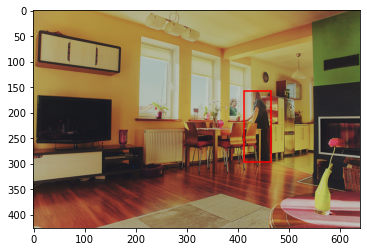

In [72]:
from PIL import Image 
from matplotlib.patches import Rectangle


image = Image.open(r"C:\Users\melti\fiftyone\coco-2017\validation\data\000000000139.jpg")
plt.imshow(image)
ax = plt.gca()
rect = Rectangle((412.8, 157.61), 53.05, 138.01,linewidth = 1.5, edgecolor = 'r', facecolor = 'none')
ax.add_patch(rect)


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization as BatchNorm 
from tensorflow.keras.layers import Dense, Dropout, Input

from tensorflow.keras.models import Model


ImportError: cannot import name 'placeholder' from 'tensorflow' (C:\Users\melti\anaconda3\envs\Tensorflow-cpu\lib\site-packages\tensorflow\__init__.py)

In [29]:
_tiny_conv  =  [
    [3, 32],
    [3, 64],
    [3, 64],

    [3, 32],
    [3, 32],
    [1, 64],

    [3, 128],
    
    [3, 64],
    [3, 64],
    [1, 128],

    [3, 256],

    [3, 128],
    [3, 128],
    [1, 256],

    [3, 512]
    ]

_conv_wts =  [
    [3, 32],
    [3, 64],
    [1, 64],
    [1, 64],
    [1, 64],
    [1, 64],
    [1, 64],
    [1, 128],
    [3, 256],
    [1, 128],
    [1, 128],
    [1, 256],
    [3, 512],
    [1, 256],
    [1, 256],
    [1, 512],
    [3, 1024],
    [1, 512],
    [1, 512],
    [1, 1024],
    [1, 512],
    [3, 1024],
    [1, 512],
    [1, 512],
    [3, 1024],
    [1, 512]
    ]

5


In [21]:
inp = Input(shape = (32,))

hidden1 = Dense(32, kernel_initializer=tf.initializers.he_uniform(),activation=tf.nn.relu, name="hidden1")

bn1 = BatchNorm() #(hidden1, axis = -1, name="bn1")

hidden2 =  Dense(bn1, kernel_initializer=tf.initializers.he_uniform(),activation=tf.nn.relu, name="hidden2")

bn2 = BatchNorm(hidden2,axis = -1, name="bn2")

hidden3 =  Dense(bn2, units=8 , kernel_initializer=tf.initializers.he_uniform(),activation=tf.nn.relu, name="hidden3")

bn3 = BatchNorm(hidden3,axis = -1, name="bn3")

out = Dense(bn3, units=1, kernel_initializer=tf.initializers.he_uniform(), activation=None, name="out")

TypeError: __init__() got multiple values for argument 'axis'

In [ ]:

# Define the number of units per hidden layer
layer_widths = [128, 64, 32]

# Set up input layer
input_layer = Input(...)  # change according to your input
x = input_layer.output

# Iteratively add the hidden layers
for n_neurons in layer_widths:
            x = Dense(n_neurons)(x)
            x = ReLU()(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)

# Add the output layer
output  = Dense(16, activation='softmax')(x)  # change according to your output


In [22]:
inp = tf.placeholder("float", [None,2], name="inp")

units = [32, 16, 8]

for unit in range(len(units)):
     inp =  tf.layers.dense(inp, units=units[unit], kernel_initializer=tf.initializers.he_uniform(),activation=tf.nn.relu,name="hidden" + str(unit + 1))
     inp = tf.layers.batch_normalization(inputs=inp, name="bn"+str(unit + 1))


out = tf.layers.dense(inp, units=1, kernel_initializer=tf.initializers.he_uniform(), activation=None, name="out")  

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
res_layers_per_stage= [1,2,8,8,4]

In [26]:
x = y = 2


True True


4 2
